### Dependencies

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
!cp -r /content/drive/MyDrive/gachon_object_detection/yolov1/* .

1. get_data.sh 파일을 통한 VOC데이터셋 다운로드

In [7]:
!sh get_data.sh

--2024-01-25 04:46:40--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtrainval_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 460032000 (439M) [application/x-tar]
Saving to: ‘VOCtrainval_06-Nov-2007.tar’

VOCtrainval_06-Nov- 100%[===================>] 438.72M  13.2MB/s    in 36s     

2024-01-25 04:47:17 (12.2 MB/s) - ‘VOCtrainval_06-Nov-2007.tar’ saved [460032000/460032000]

--2024-01-25 04:47:17--  http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar
Resolving host.robots.ox.ac.uk (host.robots.ox.ac.uk)... 129.67.94.152
Connecting to host.robots.ox.ac.uk (host.robots.ox.ac.uk)|129.67.94.152|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 451020800 (430M) [application/x-tar]
Saving to: ‘VOCtest_06-Nov-2007.tar’

VOCtest_06-Nov-2007 100%[===================

2. 사용할 라이브러리 및 util함수들 불러오기

In [8]:
import os
import torch
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torchvision.transforms.functional as FT
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from PIL import Image
from torch.utils.data import DataLoader
from utils import (
    non_max_suppression, # NMS를 계산하는 함수입니다.
    mean_average_precision, # Box mAP를 계산하는 함수입니다.
    intersection_over_union, # IoU를 계산하는 함수입니다.
    cellboxes_to_boxes, # 그리드 기준의 박스를 실제 박스로 반환하는 함수입니다.
    get_bboxes, # 예측한 box와 실제 box를 반환하는 함수입니다.
    plot_image, # 이미지를 그려주는 함수입니다.
    save_checkpoint, # 모델의 weight를 저장하는 함수입니다.
    load_checkpoint, # 저장된 모델의 weight를 불러오는 함수입니다.
)

3. 시드 고정 및 모델을 훈련시킬 장치 설정

In [9]:
seed = 123
torch.manual_seed(seed)

DEVICE = "cuda" if torch.cuda.is_available else "cpu"
print(DEVICE)

cuda


### DataLoader

1. Custom Dataset 생성

In [10]:
class VOCDataset(torch.utils.data.Dataset):
    def __init__(self, img_dir, label_dir, csv_file_path, num_grid=7, num_box=2, num_class=20, transform=None):
        '''
        클래스 변수 선언하는 함수입니다.
        '''
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.annotation = pd.read_csv(csv_file_path)
        self.num_grid = num_grid # S
        self.num_box = num_box # B
        self.num_class = num_class # C
        self.transform = transform

    def __len__(self):
        '''
        데이터의 개수를 반환하는 함수입니다.
        '''
        return len(self.annotation)

    def __getitem__(self, index):
        """
        데이터셋의 index번째의 데이터를 반환하는 함수입니다.
        """
        # 1. 이미지를 읽어옵니다.
        img_path = os.path.join(self.img_dir, self.annotation.iloc[index, 0])
        image = Image.open(img_path)

        # 2. 레이블(box)을 읽어옵니다.
        label_path = os.path.join(self.label_dir, self.annotation.iloc[index, 1])
        boxes = []
        # [class_label, x, y, width, height] 순서로 label을 읽어옵니다.
        with open(label_path) as f:
            for label in f.readlines():
                class_label, x, y, width, height = [
                    float(x) if float(x) != int(float(x)) else int(x)
                    for x in label.replace("\n", "").split()
                ]
                boxes.append([class_label, x, y, width, height])
        boxes = torch.tensor(boxes) # 취득한 box를 tensor로 변환합니다.

        # 3. 이미지와 레이블에 대해 transform을 적용합니다.
        if self.transform:
            image, boxes = self.transform(image, boxes)

        # 4. 학습을 위해 레이블(box)을 정제합니다.
        label_matrix = torch.zeros((self.num_grid, self.num_grid, self.num_class + 5 * self.num_box))
        for box in boxes:
            class_label, x, y, width, height = box.tolist() # [class_label, x, y, width, height] 형태의 box를 분리합니다.
            class_label = int(class_label) # 0~20 사이의 클래스 번호입니다.

            # 이미지를 (num_grid * num_grid) 크기의 grid로 나누고, 객체의 중점이 존재하는 grid의 위치를 찾습니다.
            # ex) (7 x 7) grid로 나눠보니, 객체의 중점은 3행 4열에 있구나!
            i, j = int(self.num_grid * x), int(self.num_grid * y)

            # 객체의 중점이 존재하는 grid(한 칸)에서 정확한 중점의 위치를 찾습니다.
            # ex) 3행 4열의 grid내에서 중점은 (0.4, 0.2)에 있구나!
            x_cell, y_cell = self.num_grid * x - i, self.num_grid * y - j
            width_cell, height_cell = (
                width * self.num_grid,
                height * self.num_grid,
            )

            # 만약 grid(한 칸)에 객체가 존재하지 않는다면, 객체를 생성합니다.
            if label_matrix[i, j, 20] == 0:
                label_matrix[i, j, 20] = 1 # grid 내부에 객체가 존재한다고 수정합니다.

                # grid 내부에 객체가 존재한다고 가정하고 작성된 label을 채워줍니다.
                box_coordinates = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell]
                )
                label_matrix[i, j, 21:25] = box_coordinates

                label_matrix[i, j, class_label] = 1 # label에서 읽어온 class 번호를 채워줍니다.

        return image, label_matrix

2. transform 정의

In [11]:
class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, img, bboxes):
        for t in self.transforms:
            img, bboxes = t(img), bboxes

        return img, bboxes

transform = Compose([transforms.Resize((448, 448)), transforms.ToTensor(),])

3. 학습과 테스트 데이터셋 생성

In [12]:
IMG_DIR = "data/images"
LABEL_DIR = "data/labels"
TRAIN_CSV_PATH = "train.csv"
TEST_CSV_PATH = "test.csv"

# 모델 학습을 위한 데이터셋을 만듭니다.
train_dataset = VOCDataset(
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
        csv_file_path=TRAIN_CSV_PATH,
        transform=transform
    )

# 모델 테스트를 위한 데이터셋을 만듭니다.
test_dataset = VOCDataset(
        img_dir=IMG_DIR,
        label_dir=LABEL_DIR,
        csv_file_path=TEST_CSV_PATH,
        transform=transform
    )

Custom Dataset에서 데이터를 어떻게 가져올까?

In [13]:
image, label_matrix = train_dataset[0]
print(f"이미지의 크기: {image.shape}")
print(f"label matrix: {label_matrix.shape}")

이미지의 크기: torch.Size([3, 448, 448])
label matrix: torch.Size([7, 7, 30])


4. DataLoader 생성

In [14]:
BATCH_SIZE = 32 # 미니 배치의 크기입니다.
NUM_WORKERS = 4 # CPU 코어의 개수입니다.

# 학습 데이터셋에 대한 DataLoader를 생성합니다.
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)

# 테스트 데이터셋에 대한 DataLoader를 생성합니다.
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
    drop_last=True,
)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:557: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Model

1. YOLO V1 모델 정의

In [15]:
architecture_config = [
    (7, 64, 2, 3),
    "M",
    (3, 192, 1, 1),
    "M",
    (1, 128, 1, 0),
    (3, 256, 1, 1),
    (1, 256, 1, 0),
    (3, 512, 1, 1),
    "M",
    [(1, 256, 1, 0), (3, 512, 1, 1), 4],
    (1, 512, 1, 0),
    (3, 1024, 1, 1),
    "M",
    [(1, 512, 1, 0), (3, 1024, 1, 1), 2],
    (3, 1024, 1, 1),
    (3, 1024, 2, 1),
    (3, 1024, 1, 1),
    (3, 1024, 1, 1),
]


class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class Yolov1(nn.Module):
    def __init__(self, in_channels=3, **kwargs):
        super(Yolov1, self).__init__()
        self.architecture = architecture_config
        self.in_channels = in_channels
        self.darknet = self._create_conv_layers(self.architecture)
        self.fcs = self._create_fcs(**kwargs)

    def forward(self, x):
        x = self.darknet(x)
        return self.fcs(torch.flatten(x, start_dim=1))

    def _create_conv_layers(self, architecture):
        layers = []
        in_channels = self.in_channels

        for x in architecture:
            if type(x) == tuple:
                layers += [
                    CNNBlock(
                        in_channels, x[1], kernel_size=x[0], stride=x[2], padding=x[3],
                    )
                ]
                in_channels = x[1]

            elif type(x) == str:
                layers += [nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2))]

            elif type(x) == list:
                conv1 = x[0]
                conv2 = x[1]
                num_repeats = x[2]

                for _ in range(num_repeats):
                    layers += [
                        CNNBlock(
                            in_channels,
                            conv1[1],
                            kernel_size=conv1[0],
                            stride=conv1[2],
                            padding=conv1[3],
                        )
                    ]
                    layers += [
                        CNNBlock(
                            conv1[1],
                            conv2[1],
                            kernel_size=conv2[0],
                            stride=conv2[2],
                            padding=conv2[3],
                        )
                    ]
                    in_channels = conv2[1]

        return nn.Sequential(*layers)

    def _create_fcs(self, grid_size, num_boxes, num_classes):
        S, B, C = grid_size, num_boxes, num_classes

        return nn.Sequential(
            nn.Flatten(),
            nn.Linear(1024 * S * S, 496),
            nn.Dropout(0.0),
            nn.LeakyReLU(0.1),
            nn.Linear(496, S * S * (C + B * 5)),
        )

In [16]:
# YOLO V1 모델을 생성합니다.
model = Yolov1(grid_size=7, num_boxes=2, num_classes=20).to(DEVICE)

2. pre-trained weight 불러오기

In [17]:
LOAD_MODEL = False
LOAD_MODEL_FILE = "196.pth"


if LOAD_MODEL:
    model.load_state_dict(torch.load(LOAD_MODEL_FILE))

### Loss

In [18]:
class YoloLoss(nn.Module):
    def __init__(self, num_grid=7, num_boxes=2, num_classes=20):
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum") # MSE Loss입니다.
        self.num_grid = num_grid # grid의 개수입니다.
        self.num_boxes = num_boxes # 예측할 box의 개수입니다.
        self.num_classes = num_classes # 예측할 class의 범주입니다.

        # 학습 데이터는 객체가 없는 grid의 비중이 높습니다.
        # 이는 모델이 불안정해질 수 있기 때문에 객체가 없는 grid의 가중치를 낮추고, 객체가 있는 grid의 가중치를 높입니다.
        self.lambda_noobj = 0.5 # 객체가 없는 grid의 가중치입니다.
        self.lambda_coord = 5 # 객체가 있는 grid의 가중치입니다.

    def forward(self, predictions, target):
        # YOLO V1 모델의 추론결과를 (batch_size, grid_num, grid_num, num_classes + num_boxes * 5)의 형태로 변환합니다.
        predictions = predictions.reshape(-1, self.num_grid, self.num_grid, self.num_classes + self.num_boxes * 5)



        # ======================= #
        #         1.BOX LOSS      #
        # ======================= #
        # 모델이 예측한 num_boxes(2개)의 box와 실제 box(1개)의 IoU를 구해, IoU가 더 높은 box의 index를 구합니다.
        iou_b1 = intersection_over_union(predictions[..., 21:25], target[..., 21:25])
        iou_b2 = intersection_over_union(predictions[..., 26:30], target[..., 21:25])
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        iou_maxes, bestbox = torch.max(ious, dim=0)

        # 실제 box에 객체가 존재하는지의 여부를 판단합니다.
        exists_box = target[..., 20].unsqueeze(3)

        # 만약 객체가 존재한다면, 모델이 예측한 2개의 box 중, IoU값이 더 높은 box를 구합니다.
        box_predictions = exists_box * (
            (
                bestbox * predictions[..., 26:30]
                + (1 - bestbox) * predictions[..., 21:25]
            )
        )
        # 모델이 예측한 box와의 비교를 위해서 실제 box를 불러옵니다.
        box_targets = exists_box * target[..., 21:25]

        # 크기가 큰 box의 오차 보다, 크기가 작은 box의 오차가 더 중요하다는 것을 명시합니다.
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        # 모델이 예측한 box와 실제 box의 차이를 구합니다.
        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )



        # ======================= #
        #      2.OBJECT LOSS      #
        # ======================= #
        # 모델이 예측한 2개의 box 중, 실제 box와 IoU가 더 높은 box의 confidence score를 구합니다.
        pred_box = (
            bestbox * predictions[..., 25:26] + (1 - bestbox) * predictions[..., 20:21]
        )

        # 모델이 예측한 confidence score와 실제 confidence score의 차이를 구합니다.
        # 이 Loss는 모델이 실제 box가 존재하는 영역을 얼마나 잘 찾는지를 보기 위함입니다.
        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 20:21]),
        )




        # ======================= #
        #     3.NO OBJECT LOSS    #
        # ======================= #
        # 모델이 예측한 2개의 box 중, 실제 box와 IoU가 더 높은 box의 confidence score를 구합니다.
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 20:21], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1),
        )

        # 모델이 예측한 confidence score와 실제 confidence score의 차이를 구합니다.
        # 이 Loss는 모델이 실제로 box가 존재하지 않는 영역을 얼마나 잘 무시하는지를 보기 위함입니다.
        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 25:26], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 20:21], start_dim=1)
        )




        # ================== #
        #     4.CLASS LOSS   #
        # ================== #

        # 모델이 예측한 2개의 box 중에서 IoU가 높은 box에 대해서 예측한 클래스와 실제 box의 클래스의 차이를 구합니다.
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., :20], end_dim=-2,),
            torch.flatten(exists_box * target[..., :20], end_dim=-2,),
        )

        # 4개의 loss를 통합하여 1개의 loss를 선언합니다.
        loss = (
            self.lambda_coord * box_loss + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )

        return loss

2. YOLO V1 모델의 loss 선언

In [19]:
loss_fn = YoloLoss()

### Train

1. 학습을 위한 파라미터 선언

In [20]:
EPOCHS = 1 # 학습 데이터셋을 학습할 횟수
LEARNING_RATE = 2e-5
optimizer = optim.Adam(
    model.parameters(), lr=LEARNING_RATE
)

2. 학습 코드 작성

In [21]:
def train(train_loader, model, optimizer, loss_fn):
    # EPOCHS만큼 학습 데이터셋을 학습합니다.
    for epoch in range(EPOCHS):
        mean_loss = []
        # 미니 배치 방식으로 학습을 진행합니다.
        for batch_idx, (x, y) in enumerate(tqdm(train_loader)):
            x, y = x.to(DEVICE), y.to(DEVICE) # 데이터셋을 디바이스로 옮깁니다.

            # 학습 데이터셋에 대해 추론 및 Loss를 구합니다.
            y_hat = model(x)
            loss = loss_fn(y_hat, y)

            mean_loss.append(loss.item())

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"{epoch}/{EPOCHS} Epoch's loss: {sum(mean_loss)/len(mean_loss):.5f}")
        save_checkpoint(model.state_dict(), f"weight/{epoch}.pth")

3. 학습 진행

In [22]:
train(train_loader, model, optimizer, loss_fn)

100%|██████████| 517/517 [05:30<00:00,  1.56it/s]


0/1 Epoch's loss: 450.42586
=> Saving checkpoint


### Test

1. YOLO v8 모델과의 비교

In [23]:
# YOLO v8의 테스트 이미지를 읽어옵니다.
TEST_IMAGE_PATH = "data/images/008973.jpg"
test_image = Image.open(TEST_IMAGE_PATH)

# 이미지를 모델에 넣기 위한 정제를 합니다.
test_transform = torchvision.transforms.Compose([
    transforms.Resize((448, 448)),
    transforms.ToTensor()
])
tensor_image = test_transform(test_image)
tensor_image = tensor_image.unsqueeze(0)
tensor_image = tensor_image.to(DEVICE)

In [24]:
# 정제된 이미지를 학습된 모델을 통해 결과를 얻습니다.
iou_threshold = 0.5
confidence_threshold = 0.5

model.eval()
with torch.no_grad():
    pred = model(tensor_image)

bboxes = cellboxes_to_boxes(pred)

nms_boxes = []
for box in bboxes:
    nms_boxes.append(non_max_suppression(
        box,
        iou_threshold,
        confidence_threshold,
        box_format="midpoint",
    ))

all_pred_boxes = []
for nms_box in nms_boxes:
    all_pred_boxes.append(nms_box)

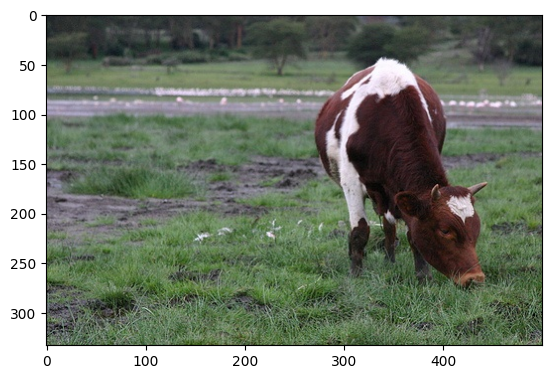

0


In [25]:
# 모델이 예측한 box를 시각화합니다.
plot_image(test_image, all_pred_boxes[0])
print(len(all_pred_boxes[0]))